# [Normalized] Analyzing the different statistical information leakage estimates (RQ1 and RQ2 (partially) in the paper)

This notebook generates the figures and tables comparing the different statistical information leakage estimates. The notebook is the same as `RQ1-RQ2(partial).ipynb` but with the normalized data, i.e., the mutual information values are normalized by the `np.log2(input_dom_size)`.

## Parsing the estimates in `result/` directory

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pprint import pprint
import os

# Set the working directory to the root of the artifact directory.
# For example, if the current working directory is 
# where this notebook is ({root}/notebook/),
# the following line sets it to the root directory.
os.chdir("../")

output_domain_size_dict = {
    "smartgrid-1": (3, 12),
    "prob-termination-5": (6, 10),
    "prob-termination-7": (8, 10),
    "smartgrid-2": (9, 12),
    "prob-termination-9": (10, 10),
    "prob-termination-12": (13, 20),
    "reservoir-4": (16, 4),
    "window-20": (20, 20),
    "window-24": (24, 24),
    "smartgrid-3": (27, 12),
    "window-28": (28, 28),
    "window-32": (32, 32),
    "reservoir-6": (64, 8),
    "smartgrid-4": (81, 12),
    "smartgrid-5": (243, 12),
    "reservoir-8": (256, 16),
    "random-walk-3": (500, 24),
    "random-walk-5": (500, 31),
    "random-walk-7": (500, 33),
    "random-walk-14": (500, 40),
    "reservoir-10": (1024, 32),
    "reservoir-12": (4096, 64),
}
subject_name_map = {
    "smartgrid-1": "SG1",
    "smartgrid-2": "SG2",
    "prob-termination-5": "PT5",
    "prob-termination-7": "PT7",
    "prob-termination-9": "PT9",
    "prob-termination-12": "PT12",
    "smartgrid-3": "SG3",
    "reservoir-6": "RV6",
    "window-20": "WD20",
    "window-24": "WD24",
    "window-28": "WD28",
    "window-32": "WD32",
    "smartgrid-4": "SG4",
    "smartgrid-5": "SG5",
    "reservoir-8": "RV8",
    "random-walk-14": "RW14",
    "random-walk-3": "RW3",
    "random-walk-5": "RW5",
    "random-walk-7": "RW7",
    "reservoir-10": "RV10",
    "reservoir-4": "RV4",
    "reservoir-12": "RV12",
}

subject_order = [
    "PT5",
    "PT7",
    "PT9",
    "PT12",
    "RW3",
    "RW5",
    "RW7",
    "RW14",
    "RV4",
    "RV6",
    "RV8",
    "RV10",
    "RV12",
    "SG1",
    "SG2",
    "SG3",
    "SG4",
    "SG5",
    "WD20",
    "WD24",
    "WD28",
    "WD32",
]

method_order = [
    "empirical",
    "ChaoFON",
    "ChaoFRN",
    "ChaoION",
    "ChaoIRN",
    "miller",
    "ChaoFOM",
    "ChaoFRM",
    "ChaoIOM",
    "ChaoIRM",
    "HyLeak",
]

method_rename = {
    "empirical": "Empirical",
    "miller": "Miller",
    "HyLeak": "HyLeak",
    "ChaoFON": "ChaoFON",
    "ChaoFRN": "ChaoFRN",
    "ChaoION": "ChaoSON",
    "ChaoIRN": "ChaoSRN",
    "ChaoFOM": "ChaoFOM",
    "ChaoFRM": "ChaoFRM",
    "ChaoIOM": "ChaoSOM",
    "ChaoIRM": "ChaoSRM",
}

/home/knittingirl/.local/lib/python3.12/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
df = pd.DataFrame(
    columns=["subject", "GT", "ratio", "method", "MI", "SE", "o.e."]
)
#Keeping track of the first time this loop is run.
first_run = True
for subject in output_domain_size_dict.keys():
    data_path = f"result/esti-merged-{subject}-i-xy.csv"
    if os.path.exists(data_path) == False:
        print(f"WARN: {data_path} not found")
    data = pd.read_csv(data_path)
    GT = data["GT"].values[0]
    data = data.drop(columns=["GT"])
    data_melt = data.melt(
        id_vars=["Nx", "trial"], var_name="method", value_name="MI"
    )
    # var order to method_order
    data_melt["method"] = pd.Categorical(data_melt["method"], method_order)
    # rename method
    data_melt["method"] = data_melt["method"].map(method_rename)
    input_dom_size = output_domain_size_dict[subject][0]
    data_melt["SE"] = (
        (data_melt["MI"] - GT) / np.log2(input_dom_size)
    ) ** 2
    data_mean = (
        data_melt.drop(columns=["SE"])
        .groupby(["Nx", "method"], observed=False)
        .mean()
        .reset_index()
        .drop(columns=["trial"])
    )
    data_mse = (
        data_melt.drop(columns=["MI"])
        .groupby(["Nx", "method"], observed=False)
        .mean()
        .reset_index()
        .drop(columns=["trial"])
    )
    data_mean = data_mean.merge(data_mse, on=["Nx", "method"])
    NS_x, NS_y = output_domain_size_dict[subject]
    data_mean["ratio"] = data_mean["Nx"] / NS_y
    data_mean.loc[data_mean["ratio"] < 1, "ratio"] = 0.5
    data_mean["subject"] = subject_name_map[subject]
    data_mean["GT"] = GT
    data_mean["o.e."] = data_mean["MI"] - GT > 0
    data_mean["input_dom_size"] = NS_x
    
    #Avoids concatention with an empty data frame.
    if first_run == True:
        df = data_mean.copy()
        first_run = False
    else:
        df = pd.concat([df, data_mean], ignore_index=True)
df = df.dropna(subset=["MI"])
df["bias"] = (df["MI"] - df["GT"]) / np.log2(df["input_dom_size"])
display(df)

/tmp/ipykernel_26762/2940985275.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_mean], ignore_index=True)
/tmp/ipykernel_26762/2940985275.py:45: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, data_mean], ignore_index=True)


,subject,GT,ratio,method,MI,SE,o.e.,Nx,input_dom_size,bias
0,SG1,0.065825,0.5,Empirical,0.394855,0.050590,True,6.0,3.0,0.207595
1,SG1,0.065825,0.5,ChaoFON,0.442915,0.064090,True,6.0,3.0,0.237917
2,SG1,0.065825,0.5,ChaoFRN,0.398220,0.051927,True,6.0,3.0,0.209718
3,SG1,0.065825,0.5,ChaoSON,0.340180,0.038469,True,6.0,3.0,0.173099
4,SG1,0.065825,0.5,ChaoSRN,0.308041,0.030207,True,6.0,3.0,0.152821
...,...,...,...,...,...,...,...,...,...,...
963,RV12,1.604873,5.0,ChaoFOM,1.774327,0.000199,True,320.0,4096.0,0.014121
964,RV12,1.604873,5.0,ChaoFRM,1.776545,0.000205,True,320.0,4096.0,0.014306
965,RV12,1.604873,5.0,ChaoSOM,1.625853,0.000003,True,320.0,4096.0,0.001748
966,RV12,1.604873,5.0,ChaoSRM,1.625842,0.000003,True,320.0,4096.0,0.001747


## Mean bias and MSE comparison (Figure 4 and 5 in the paper)

The mean bias and MSE for each estimate are plotted as a boxplot.

/tmp/ipykernel_26762/3547885941.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_26762/3547885941.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=18)


<Axes: xlabel='Sample Ratio', ylabel='Mean Bias'>

/tmp/ipykernel_26762/3547885941.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_26762/3547885941.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(yticklabels, fontsize=18)


<Axes: xlabel='Sample Ratio', ylabel='MSE'>

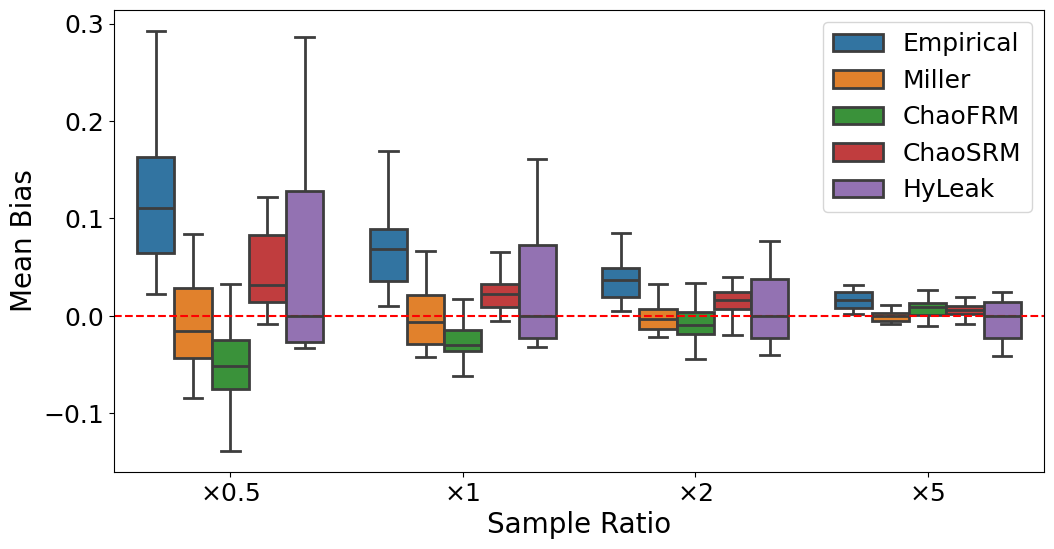

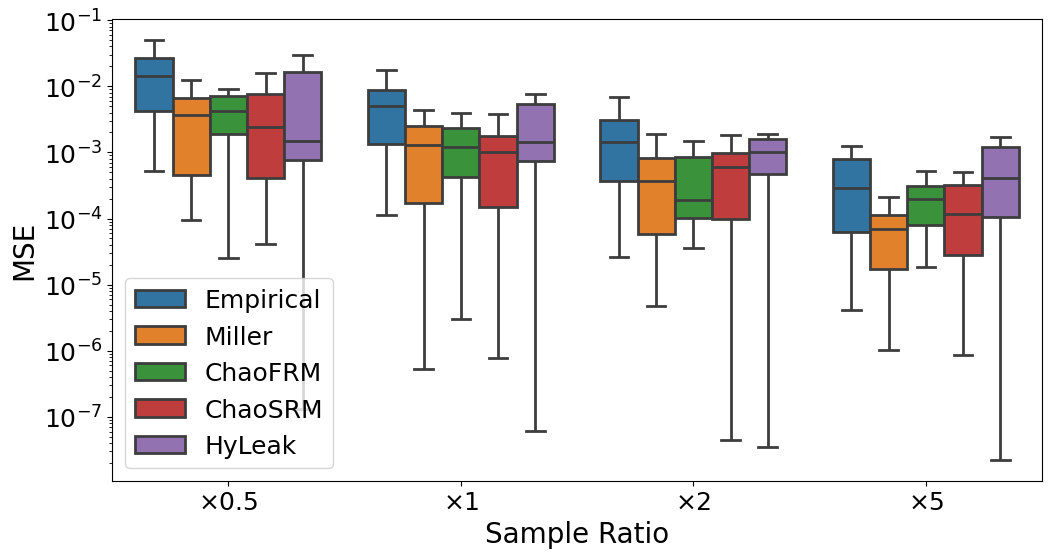

In [3]:
method_order = ["Empirical", "Miller", "ChaoFRM", "ChaoSRM", "HyLeak"]
df_temp = df.drop(columns=["GT", "MI"])
df_temp = df_temp.loc[df_temp["method"].isin(method_order)]
df_temp["method"] = pd.Categorical(df_temp["method"], method_order)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="ratio",
    y="bias",
    hue="method",
    data=df_temp,
    ax=ax,
    linewidth=2,
    showfliers=False,
)
ax.axhline(y=0, color="red", linestyle="--")
ax.set_xlabel(r"Sample Ratio", fontsize=20)
ax.set_xticklabels(
    [r"$\times$0.5", r"$\times$1", r"$\times$2", r"$\times$5"], fontsize=18
)
ax.set_ylabel(r"Mean Bias", fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)
ax.legend(loc="upper right", ncol=1, fontsize=18)
display(ax)

fig, ax = plt.subplots(figsize=(12, 6))
sns.boxplot(
    x="ratio",
    y="SE",
    hue="method",
    data=df_temp,
    ax=ax,
    linewidth=2,
    showfliers=False,
)
ax.set_xlabel(r"Sample Ratio", fontsize=20)
ax.set_xticklabels(
    [r"$\times$0.5", r"$\times$1", r"$\times$2", r"$\times$5"], fontsize=18
)
ax.set_ylabel(r"MSE", fontsize=20)
yticklabels = ax.get_yticklabels()
ax.set_yticklabels(yticklabels, fontsize=18)
ax.legend(loc="lower left", ncol=1, fontsize=18)
ax.set_yscale("log")

display(ax)

## Statistical tests for RQ1

The Wilcoxon signed-rank test is performed to compare the mean squared error of the different estimates.

In [4]:
from scipy import stats


def sttest(method1, method2, ratio=None):
    df_temp = df.loc[df["ratio"] == ratio] if ratio else df
    mse_m1 = df_temp[df_temp["method"] == method1]["SE"].values
    mse_m2 = df_temp[df_temp["method"] == method2]["SE"].values
    stat, p = stats.wilcoxon(mse_m1, mse_m2, alternative="greater")
    print(
        f"({len(mse_m1)}) method1: {method1} ({np.mean(mse_m1):.2e}), method2: {method2} ({np.mean(mse_m2):.2e}), ratio: {ratio}, p: {p:.4f}"
    )


for ratio in [0.5, 1, 2, 5]:
    for m1, m2 in [
        ("Empirical", "Miller"),
        ("Empirical", "ChaoFRM"),
        ("Empirical", "ChaoSRM"),
        ("Empirical", "HyLeak"),
        ("Miller", "ChaoFRM"),
        ("Miller", "ChaoSRM"),
        ("Miller", "HyLeak"),
        ("ChaoFRM", "ChaoSRM"),
        ("ChaoFRM", "HyLeak"),
        ("ChaoSRM", "HyLeak"),
    ]:
        sttest(m1, m2, ratio)

(22) method1: Empirical (2.48e-02), method2: Miller (3.77e-03), ratio: 0.5, p: 0.0001
(22) method1: Empirical (2.48e-02), method2: ChaoFRM (5.54e-03), ratio: 0.5, p: 0.0006
(22) method1: Empirical (2.48e-02), method2: ChaoSRM (4.44e-03), ratio: 0.5, p: 0.0000
(22) method1: Empirical (2.48e-02), method2: HyLeak (1.74e-02), ratio: 0.5, p: 0.0000
(22) method1: Miller (3.77e-03), method2: ChaoFRM (5.54e-03), ratio: 0.5, p: 0.8549
(22) method1: Miller (3.77e-03), method2: ChaoSRM (4.44e-03), ratio: 0.5, p: 0.7277
(22) method1: Miller (3.77e-03), method2: HyLeak (1.74e-02), ratio: 0.5, p: 0.8622
(22) method1: ChaoFRM (5.54e-03), method2: ChaoSRM (4.44e-03), ratio: 0.5, p: 0.3051
(22) method1: ChaoFRM (5.54e-03), method2: HyLeak (1.74e-02), ratio: 0.5, p: 0.8147
(22) method1: ChaoSRM (4.44e-03), method2: HyLeak (1.74e-02), ratio: 0.5, p: 0.9119
(22) method1: Empirical (8.48e-03), method2: Miller (1.61e-03), ratio: 1, p: 0.0000
(22) method1: Empirical (8.48e-03), method2: ChaoFRM (2.04e-03), r

## Statistical tests for RQ2

The Wilcoxon signed-rank test is performed to compare the mean squared error of the different configurations of our unseen event-aware estimator. We named the eight variants of our estimator as the following scheme: 
- ‘Chao’ 
- \+ ‘F’ (for the FL approach) or ‘S’ (for the BS approach) 
- \+ ‘O’ (for the original MD estimates) or ‘R’ (for the refined MD estimates) 
- \+ ‘N’ (for no bias correction) or ‘M’ (for Miller’s bias correction).


In [5]:
sttest("Empirical", "ChaoFON")
sttest("Empirical", "ChaoFRN")
sttest("Empirical", "ChaoSON")
sttest("Empirical", "ChaoSRN")

(88) method1: Empirical (9.02e-03), method2: ChaoFON (3.56e-03), ratio: None, p: 0.0002
(88) method1: Empirical (9.02e-03), method2: ChaoFRN (2.96e-03), ratio: None, p: 0.0000
(88) method1: Empirical (9.02e-03), method2: ChaoSON (3.94e-03), ratio: None, p: 0.0000
(88) method1: Empirical (9.02e-03), method2: ChaoSRN (3.10e-03), ratio: None, p: 0.0000


In [6]:
sttest("ChaoFON", "ChaoSON")
sttest("ChaoFRN", "ChaoSRN")
print()
sttest("ChaoFON", "ChaoFRN")
sttest("ChaoSON", "ChaoSRN")

(88) method1: ChaoFON (3.56e-03), method2: ChaoSON (3.94e-03), ratio: None, p: 0.6018
(88) method1: ChaoFRN (2.96e-03), method2: ChaoSRN (3.10e-03), ratio: None, p: 0.5232

(88) method1: ChaoFON (3.56e-03), method2: ChaoFRN (2.96e-03), ratio: None, p: 0.0000
(88) method1: ChaoSON (3.94e-03), method2: ChaoSRN (3.10e-03), ratio: None, p: 0.0000


In [7]:
sttest("Empirical", "Miller")
sttest("ChaoFRN", "ChaoFRM")
sttest("ChaoSRN", "ChaoSRM")

(88) method1: Empirical (9.02e-03), method2: Miller (1.49e-03), ratio: None, p: 0.0000
(88) method1: ChaoFRN (2.96e-03), method2: ChaoFRM (2.09e-03), ratio: None, p: 0.0817
(88) method1: ChaoSRN (3.10e-03), method2: ChaoSRM (1.67e-03), ratio: None, p: 0.0000
